In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

/Users/pierre/Library/Python/2.7/lib/python/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
d = pd.read_csv('../data/data_encode_pierre.csv')
words = pd.read_csv('../data/words_1487722385_labeled.csv')


In [6]:
lines = open('../data/eeg_channels.txt').readlines()
lines = [line.strip() for line in lines]

CHANNELS = dict()
for line in lines:
    num, _, label = line.partition(' ')
    num = int(num) - 1
    CHANNELS[num] = label

In [7]:
d.shape

(16644, 6)

In [9]:
d.head()

,timestamps,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Marker
0,1.487722e+09,-221.948,-216.828,-217.685,-216.970,0
1,1.487722e+09,-426.390,-424.333,-429.987,-426.180,0
2,1.487722e+09,-394.587,-398.391,-392.370,-391.367,0
3,1.487722e+09,-213.268,-210.859,-212.568,-208.144,0
4,1.487722e+09,-332.492,-334.104,-336.827,-342.100,0


In [14]:
t = d.timestamps


In [17]:
eeg = np.array(d.ix[:, 1:5])
eeg = eeg[250:77500,]

tag = np.array(d.ix[:, 'Marker'])
tag = tag[250:]

In [45]:
prev = 0

for i, t in enumerate(tag):
    if t != 0:
        prev = t
    elif i != 0:
        tag[i] = prev


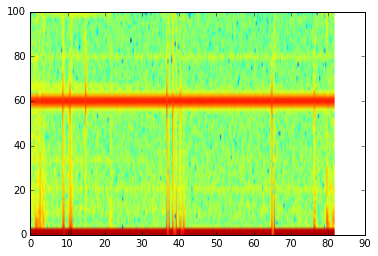

In [46]:
_ = plt.specgram(eeg[:, 0], NFFT=128, Fs=200, noverlap=64)

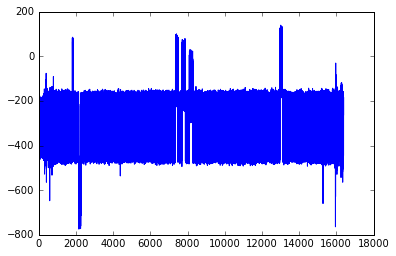

In [47]:
plt.plot(eeg[:, 0])

In [48]:
from scipy import signal

In [49]:
# filter from 5 to 35 Hz, helps remove 60Hz noise and replicates paper
## also helps remove the DC line noise (baseline drift)
## 125 is half the sampling rate (250Hz/2)
b, a = signal.butter(4, (2.0/125, 35.0/125), btype='bandpass') 
b, a

(array([ 0.01222321,  0.        , -0.04889285,  0.        ,  0.07333928,
         0.        , -0.04889285,  0.        ,  0.01222321]),
 array([  1.        ,  -5.71974179,  14.41372236, -21.04755049,
         19.59013879, -11.93007722,   4.63594027,  -1.04851038,   0.10608002]))

In [50]:
eeg_f = signal.lfilter(b, a, eeg, axis=0)

In [51]:
## the filter needs a couple samples to converge
## honestly 500 is very conservative, but we don't these samples anyway so whatever
eeg_f = eeg_f[500:]
tag = tag[500:]

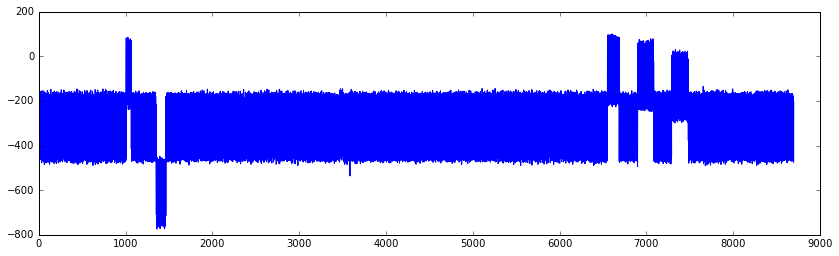

In [52]:
plt.figure(figsize=(14, 4))
plt.plot(eeg[800:9500, 0]) ## raw data

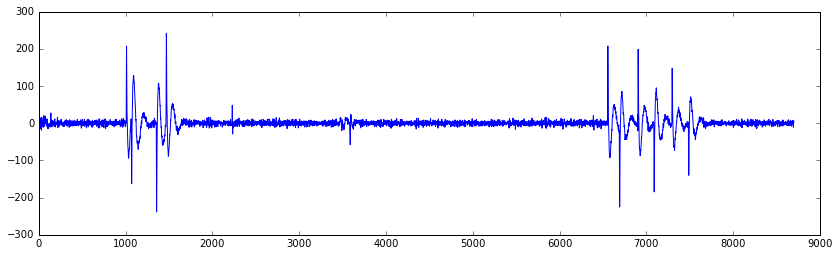

In [53]:
plt.figure(figsize=(14, 4))
plt.plot(eeg_f[300:9000, 0])

In [54]:
from sklearn.decomposition import FastICA

In [55]:
ica = FastICA()
sources = ica.fit_transform(eeg_f)
means = ica.mean_.copy()
mixing = ica.mixing_.copy()

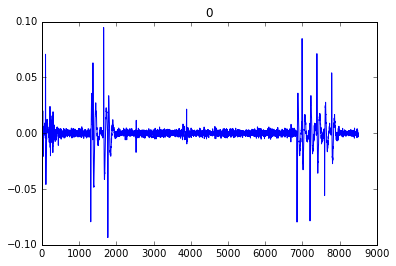

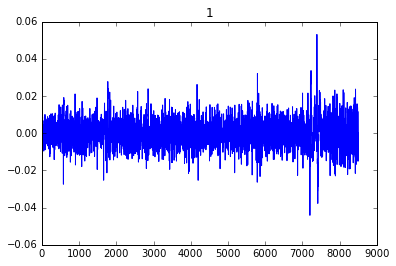

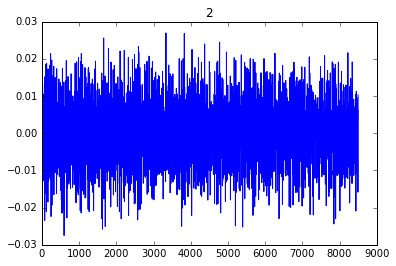

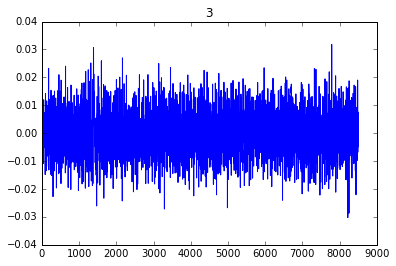

In [56]:
## look at the plots to find the eyeblink component
## TODO: make a more robust eyeblink component finder
for i in range(ica.components_.shape[0]):
    plt.figure()
    plt.plot(sources[:8500, i])
    plt.title(i)

In [57]:
eye_blinks_ix = 3

In [58]:
mixing[:, eye_blinks_ix] = 0 # setting eyeblink component to 0
eeg_ff = sources.dot(mixing.T) + means # this is the ICA inverse transform


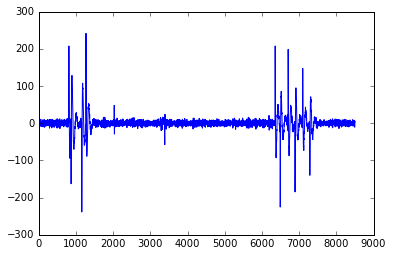

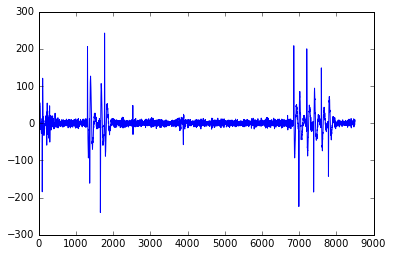

In [59]:
plt.figure()
plt.plot(eeg_f[500:9000, 0])

plt.figure()
plt.plot(eeg_ff[:8500, 0])

In [60]:
word_dict = {}
for i in xrange(words.shape[0]):
    d = dict(words.ix[i])
    word_dict[d['id']] = d

In [61]:
word_starts = []
prev_t = None

for i, t in enumerate(tag):
    if t != -1 and t != 0 and t != prev_t:
        w = word_dict[t]
        word_starts.append( {'index': i, 
                             'word': t,
                             'dict': w} )
    prev_t = t

In [62]:
## this confirms that there's ~2.5 seconds between words
np.diff([x['index'] for x in word_starts]) / 250.0

array([ 2.02 ,  2.008,  2.02 ,  2.016,  2.02 ,  2.016,  2.012,  2.032,
        2.02 ,  2.016,  2.012,  2.024,  2.032,  1.996,  2.004,  2.024,
        2.012,  2.024,  2.016,  2.028,  2.02 ,  2.02 ,  2.008,  2.028,
        2.016,  2.028,  2.016,  2.012])

In [63]:
recognized = np.array([w['dict']['recognized'] for w in word_starts])

In [72]:
eeg_trials = np.zeros((8, len(word_starts), int(500)))
time = np.arange(0, eeg_trials.shape[2], 1) / 250.0 - 0.5

In [74]:
for c in range(4):
    for i in range(len(word_starts)):
        d = word_starts[i]
        start = d['index']
        if start < 100:
            continue
        # 100 samples = 0.5s, 400 samples = 2.0 s
        # we want 0.5s before the stimulus presentation and 2.0 seconds after
        eeg_trials[c, i, :] = eeg_ff[start-100:start+400, c] 

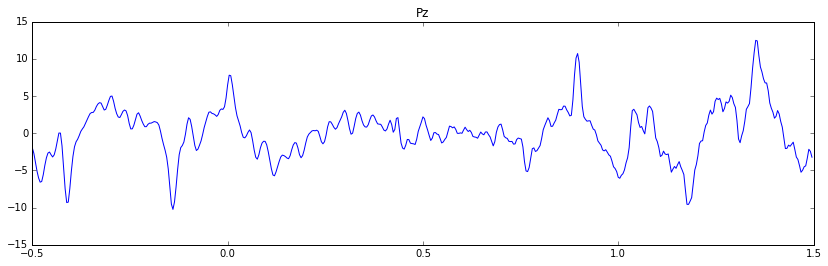

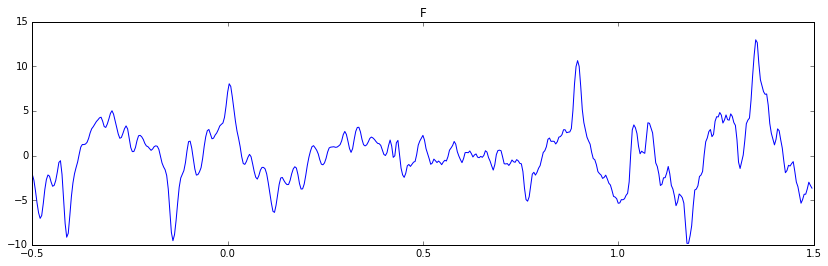

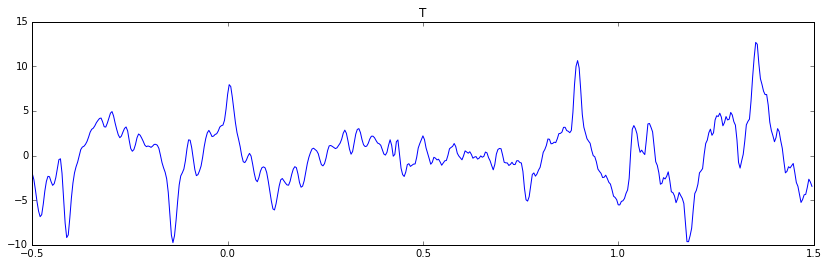

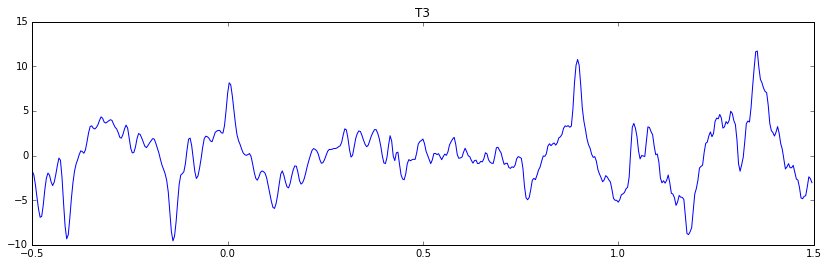

In [77]:
for c in range(4):
    plt.figure(figsize=(14, 4))
    _ = plt.plot(time, np.mean(eeg_trials[c], axis=0))
    plt.title(CHANNELS[c])

In [80]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


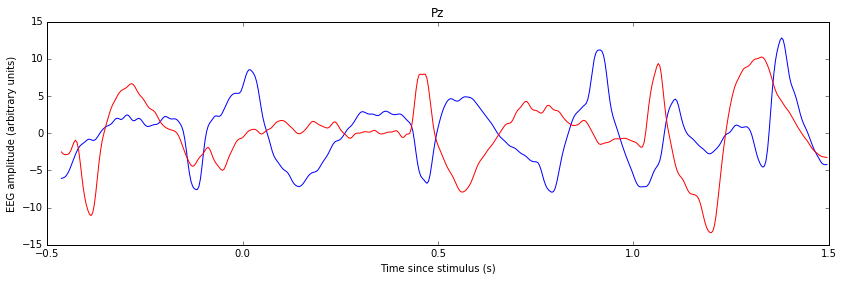

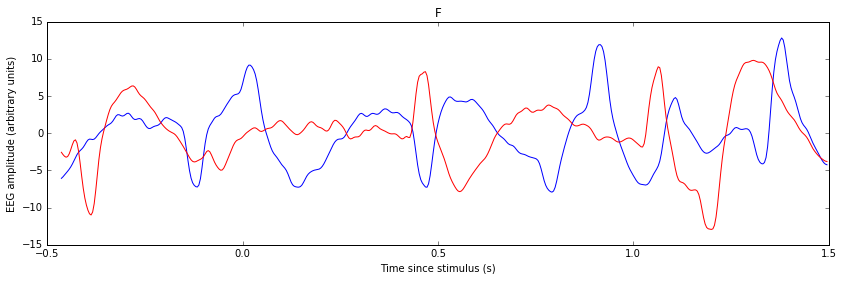

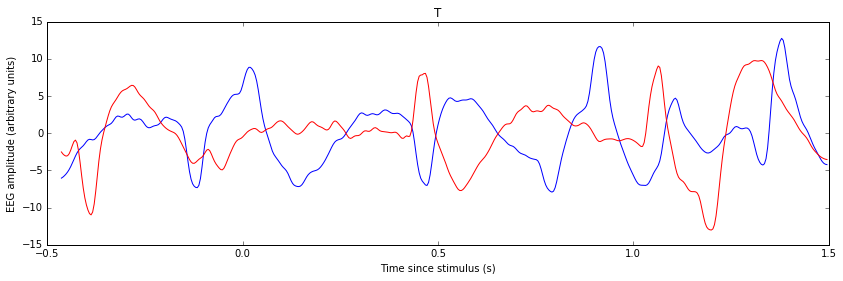

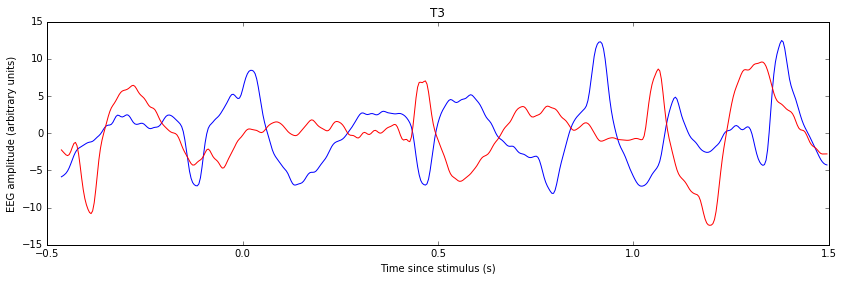

In [82]:
## this shows the ERPs for -0.5s to 2.5s with 0s = when stimulus is shown
## blue is for remembered words
## red is for not remembered words

N_AVG = 10

for i in range(4):
    plt.figure(figsize=(14, 4))
    
    rec = np.mean(eeg_trials[i][recognized], axis=0)
    rec = moving_average(rec, n=N_AVG)
    _ = plt.plot(time[(N_AVG-1):], rec, c='blue')
    
    not_rec = np.mean(eeg_trials[i][~recognized], axis=0)
    not_rec = moving_average(not_rec, n=N_AVG)
    _ = plt.plot(time[(N_AVG-1):], not_rec, c='red')
    plt.title(CHANNELS[i])
    
    plt.xlabel('Time since stimulus (s)')
    plt.ylabel('EEG amplitude (arbitrary units)')

## 